In [1]:
!pip install tzlocal==2.0

In [2]:
!pip install codecarbon

In [1]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset

from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from torch.autograd import Variable


from tqdm import tqdm
from codecarbon import EmissionsTracker



# Check assigned GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 42

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


Sun Jul 18 14:04:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
#!tar -zxvf MNIST.tar.gz

from torchvision.datasets import MNIST
transforms_mnist = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

mnist_data_train = MNIST(root = '../data/mnist/', train=True, download=True, transform=transforms_mnist)
trainloader = torch.utils.data.DataLoader(mnist_data_train, batch_size=128, shuffle=True)

mnist_data_test = MNIST(root = '../data/mnist/', train=False, download=True, transform=transforms_mnist)
testloader = torch.utils.data.DataLoader(mnist_data_test, batch_size=128, shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))

Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [4]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


In [5]:
dataiter = iter(trainloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


## Visualize Data

In [6]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [7]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


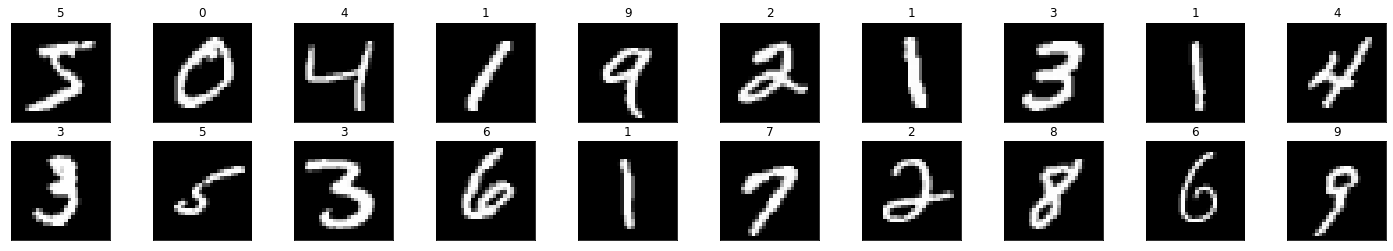

In [8]:
visualize(mnist_data_train)

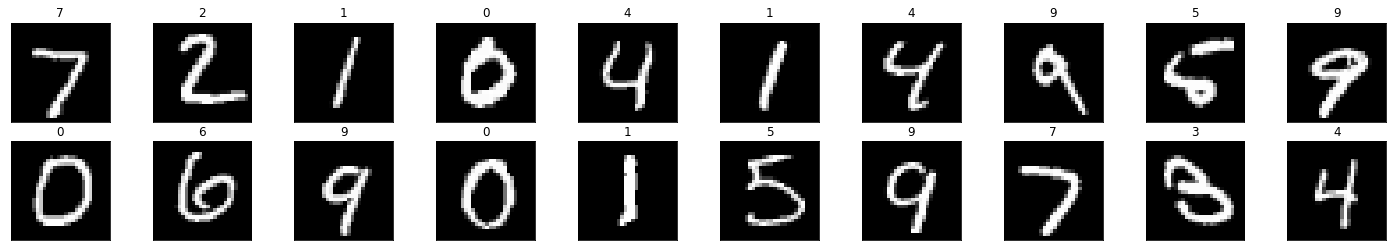

In [9]:
visualize(mnist_data_test)

In [10]:
class MNIST_2NN(nn.Module):
  """
  A simple multilayer-perceptron with 2-hidden layers with 200 units each
  using ReLu activations

  Total Expected Params: 199,210
  """
  def __init__(self):
    super(MNIST_2NN, self).__init__()

    self.fc1 = nn.Linear(28*28, 200)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(200, 200)
    self.relu = nn.ReLU()
    self.fc3 = nn.Linear(200, 10)

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)

    return x

In [11]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.2)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

In [12]:
mnist_mlp = MNIST_2NN()
mnist_cnn = MNIST_CNN()

if torch.cuda.is_available():
  mnist_mlp.cuda()
  mnist_cnn.cuda()

print("MNIST MLP SUMMARY")
print(summary(mnist_mlp, (1, 28*28)))

print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28,28)))

MNIST MLP SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 200]         157,000
              ReLU-2               [-1, 1, 200]               0
            Linear-3               [-1, 1, 200]          40,200
              ReLU-4               [-1, 1, 200]               0
            Linear-5                [-1, 1, 10]           2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.76
Estimated Total Size (MB): 0.77
----------------------------------------------------------------
None

MNIST CNN SUMMARY
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]             832

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [13]:
model = mnist_mlp

In [14]:
def clip_grad_norm(parameters, max_norm, norm_type=2):
    parameters = list(filter(lambda p: p.grad is not None, parameters))
    total_norm = 0
    for p in parameters:
        param_norm = p.grad.data.norm(norm_type)
        total_norm += param_norm.item() ** norm_type

    return total_norm

In [15]:
def train_dp(model, trainloader, criterion, optimizer, lr_scheduler,noise, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches = 1
    S = 1
    z = noise # DP-SGD with sampling rate = 4.37% and noise_multiplier = 6.6 iterated over 1145 steps satisfies differential privacy with eps = 1 and delta = 0.0001.
            # The optimal RDP order is 20.0.
    sigma = z * S
    for batch_idx, data in tqdm(enumerate(trainloader, 0), leave=True):
        inputs, labels = data
        inputs, labels = Variable(inputs.view(-1, 28*28)).cuda(), Variable(labels).cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += torch.mean(loss).item()

        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())

        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)
        saved_var = dict()
        for tensor_name, tensor in model.named_parameters():
            saved_var[tensor_name] = torch.zeros_like(tensor)

        for j in losses:
            j.backward(retain_graph=True)
            torch.nn.utils.clip_grad_norm_(model.parameters(), S)
            for tensor_name, tensor in model.named_parameters():
                new_grad = tensor.grad
                saved_var[tensor_name].add_(new_grad)
            model.zero_grad()

        for tensor_name, tensor in model.named_parameters():
            if device.type =='cuda':
                noise = torch.cuda.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            else:
                noise = torch.FloatTensor(tensor.grad.shape).normal_(0, sigma)
            saved_var[tensor_name].add_(noise)
            tensor.grad = saved_var[tensor_name] / num_microbatches
        optimizer.step()

        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)

    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [16]:
def train_without_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train'):
    """
    Differentially Private version of the training procedure
    :param trainloader:
    :param model:
    :param optimizer:
    :param epoch:
    :return:
    """
    model.train()
    running_loss = 0.0
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []
    num_microbatches=1
    for batch_idx, (inputs,labels) in enumerate(tqdm(trainloader)):
        inputs, labels = torch.reshape(inputs,(-1, 28*28)).cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
    
        optimizer.step()

        running_loss += torch.mean(loss).item()
        true_labels.append(labels.detach().cpu())
        pred_labels.append(preds.detach().cpu())
        losses = torch.mean(loss.reshape(num_microbatches, -1), dim=1)

        epoch_loss += torch.mean(loss.detach().cpu()).item()
        epoch_acc += torch.sum(preds == labels.data)
        batch_num += 1
        samples_num += len(labels)
    return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [17]:
def test(model, testloader, criterion, optimizer, lr_scheduler, phase='test'):
    model.eval()
    epoch_loss = 0.
    epoch_acc = 0.
    
    batch_num = 0.
    samples_num = 0.
    
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, data in enumerate(testloader):
            inputs, labels = data
            inputs, labels = Variable(inputs.view(-1, 28*28)).cuda(), Variable(labels).cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            true_labels.append(labels.detach().cpu())
            pred_labels.append(preds.detach().cpu())

            epoch_loss += torch.mean(loss.detach().cpu()).item()
            epoch_acc += torch.sum(preds == labels.data)
            batch_num += 1
            samples_num += len(labels)
        return epoch_loss / batch_num, epoch_acc / samples_num, torch.cat(true_labels).numpy(), torch.cat(pred_labels).numpy()

In [18]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_mlp.parameters(), lr=1e-2, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [28]:
def train_with_dp_main(epsilon,noise):
  tracker = EmissionsTracker(project_name='epsilon='+str(epsilon))
  tracker.start()
  epoch = 0
  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []
  while(True):
    epoch = epoch+1
    train_loss, train_acc, _, _ = train_dp(model, trainloader, criterion, optimizer, lr_scheduler,noise, phase='train')
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    test_loss,test_acc,_,_= test(model,testloader,criterion,optimizer,lr_scheduler)
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    if(test_acc > 0.70 or epoch == 200):
      break
  emissions: float = tracker.stop()
  print(emissions)
  return train_losses,train_accuracies,test_losses,test_accuracies

In [30]:
train_loss,train_acc,test_loss,test_acc = train_with_dp_main(5,0.894)

In [25]:
def train_without_DP_main():
  tracker = EmissionsTracker(project_name='epsilon='+"infinity")
  tracker.start()
  epoch = 0
  train_losses = []
  train_accuracies = []
  test_losses = []
  test_accuracies = []
  while(True):
    epoch = epoch+1
    train_loss, train_acc, _, _ = train_without_dp(model, trainloader, criterion, optimizer, lr_scheduler, phase='train')
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')
    test_loss,test_acc,_,_= test(model,testloader,criterion,optimizer,lr_scheduler)
    print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    if(test_acc > 0.70 or epoch == 200):
      break
  emissions: float = tracker.stop()
  print(emissions)
  return train_losses,train_accuracies,test_losses,test_accuracies

In [27]:
non_train_loss,non_train_acc,non_test_loss,non_test_acc = train_without_DP_main()